# Creating a custom PPF function

Running through various attempts to create a custom ppf funtion where the pdf is a mixture of 2 normals. Given a normal distribution we want an additional parameter `e` that determines the two normals that we mix. With `P=0.5` we chose from a normal distribution with a variance of either:
 - `sigma**2` * `(1 - e)`
 - `sigma**2` * `(1 + e)`

Such that overall the variance of our mixed distribution will remain as `sigma**2`. Given the above info we can clearly write down our pdf. However the problem occurs once we want to start sampling from this distribution. Unless we apriori compute a custom percentage point function (ppf) - the inverse cdf - we will have to very expensively compute numerically this function each time.

This is an attempt to demonstrate why we need to compute it ourselves and why mixing 2 standard normal ppfs won't work.

## Attempt 1: Custom ppf as average of normal ppfs

So to try and make use of the highly optimised c code in the cephes library that underpins the numerical routines in SciPy we want to try to write our ppf function on top of the SciPy implemented normal ppf functions. This will make our sampling **rapid** which is the aim of the game. Let's see how this would look in practise. First, let's use SciPy to plot the 3 ppfs:
 - the ppf for our distribution as created cleverly by SciPy using numerical integration (very slow)
 - the 'low var' ppf in isolation
 - the 'high var' ppf in isolation

What we are hoping is that the actual correct SciPy computed version lies within the 'low var' and 'high var' versions. That way we could just implement our own ppf as a linear combo of these 2 and be done with it. Let's first define our distribution - we only know the closed form pdf so we just state that and SciPy uses magic to do the rest. The issue is that that magic is very time consuming when it comes to sampling but at least it works as a benchmark to compare to.

In [1]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 

In [2]:
# define our gaussian look-a-like distribution
class my_gaussian(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
        
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        def norm_p(x, loc=0, scale=1):
            return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * np.sqrt(2.0 * np.pi))
    
        low = norm_p(x, scale=(1 - self.e)**0.5)
        high = norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)

Let's also define it trying to leverage SciPy's built in normal pdf function.

In [39]:
?? stats._continuous_distns._norm_pdf

Signature:  stats._continuous_distns._norm_pdf(x)
Docstring: <no docstring>
Source:   
def _norm_pdf(x):
    return np.exp(-x**2/2.0) / _norm_pdf_C
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py
Type:      function


In [46]:
stats._continuous_distns._norm_pdf_C

2.5066282746310002

In [47]:
stats._continuous_distns._norm_pdf_C == np.sqrt(2 * np.pi)

True

So it turns out that their built in normal pdf function is written in python - the only potential speed improvement being saving on computing `sqrt(2 * pi)`. Let's just implement both and speed check them.

In [190]:
# define our gaussian look-a-like distribution
class my_dist(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
        
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        def norm_p(x, loc=0, scale=1):
            # return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * np.sqrt(2.0 * np.pi))
            return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * 2.5066282746310002)
    
        low = norm_p(x, scale=(1 - self.e)**0.5)
        high = norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)

In [73]:
# define our gaussian look-a-like distribution
class my_dist_sp_pdf(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
        
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        low = _norm_pdf(x / (1 - self.e)**0.5) / (1 - self.e)**0.5
        high = _norm_pdf(x / (1 + self.e)**0.5) / (1 + self.e)**0.5
        return 0.5 * (low + high)

Now let's create them and:
 - compare pdf values
 - compare pdf compute times

In [186]:
e = 0.5
my_d = my_dist(e, name='my_dist')
my_d_2 = my_dist_sp_pdf(e, name='my_dist_2')

xs = np.linspace(-4, 4, 100001)

my_d_pdf = my_d.pdf(xs)
my_d_pdf_2 = my_d_2.pdf(xs)

In [79]:
np.sum([x - y for x,y in zip(my_d_pdf, my_d_pdf_2)])

-9.302443797903903e-14

So they are almost identical.

In [80]:
%timeit my_d.pdf(xs)

6.04 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
%timeit my_d_2.pdf(xs)

6.97 ms ± 526 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So we're slightly faster over `100,000` numbers but it's much of a muchness. Let's continue with our version for now just as it means we have a bit more control over everything. Now that we've defined our distribution class we can let SciPy do the rest to generate a ppf for it. We can then compare that to the ppf SciPy will generate for the 'low var' and 'high var' cases.

In [92]:
xs = np.linspace(0, 1, 1001)

# correct one
my_d_ppfs = my_d.ppf(xs)
# low var
low_var_ppfs = stats.norm.ppf(xs, scale=(1 - e)**0.5)
#high var
high_var_ppfs = stats.norm.ppf(xs, scale=(1 + e)**0.5)

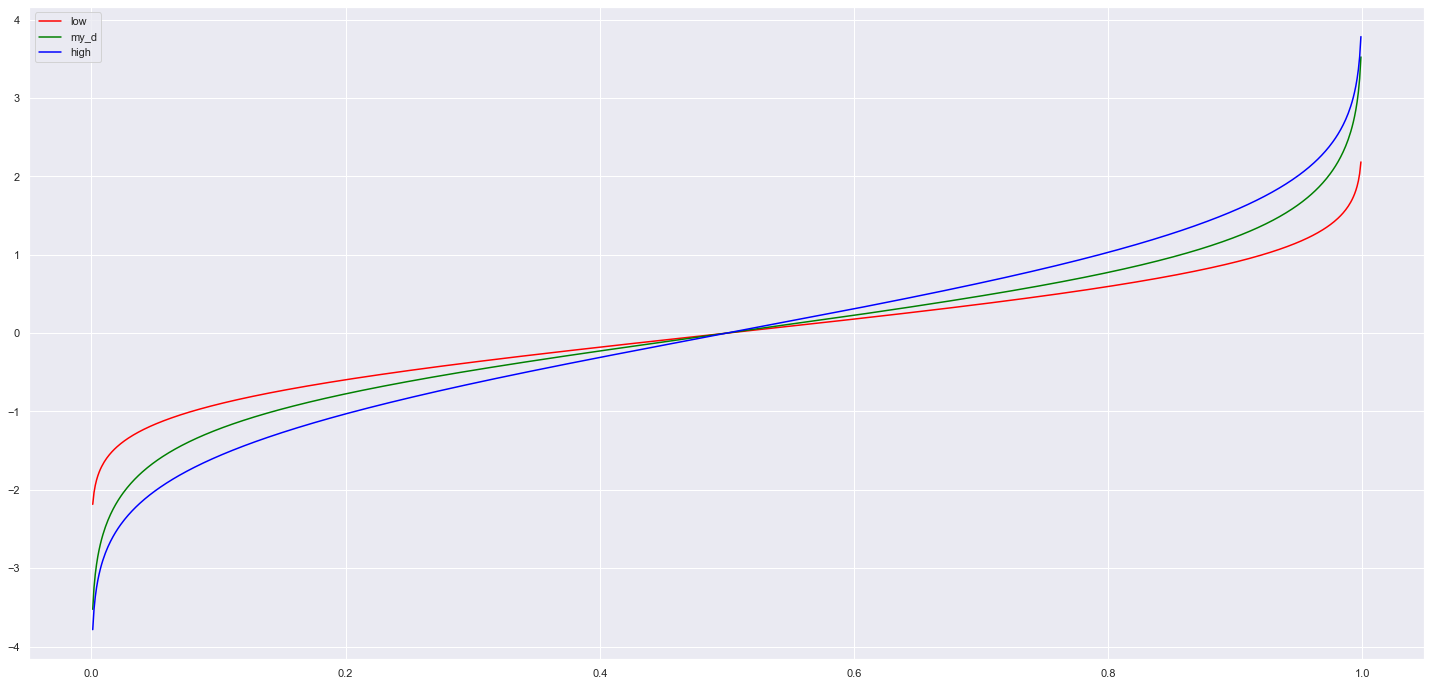

In [93]:
fig, ax = plt.subplots(figsize=(25,12))

ax.plot(xs, low_var_ppfs, label='low', color='red')
ax.plot(xs, my_d_ppfs, label='my_d', color='green')
ax.plot(xs, high_var_ppfs, label='high', color='blue')
ax.legend();

So it certainly looks like we sit neatly in the middle - let's now compare how we look if we apply the linear average we want.

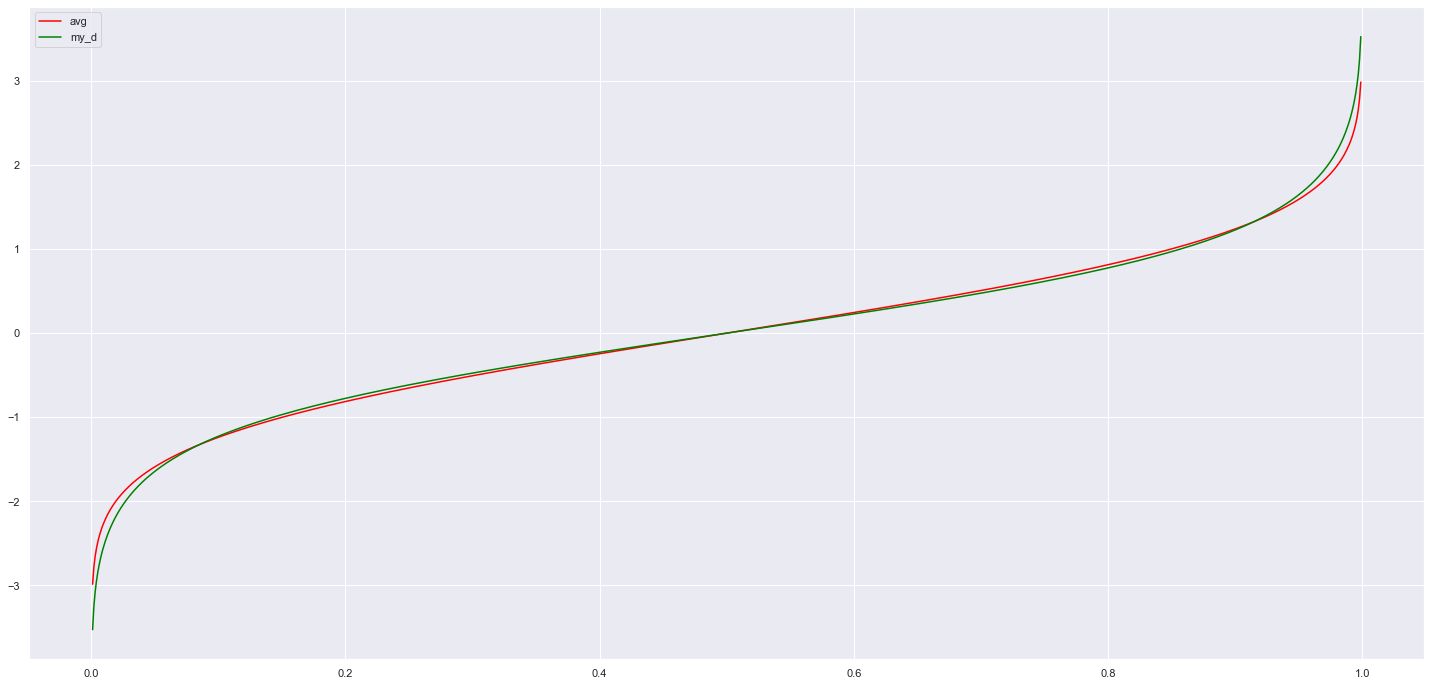

In [99]:
fig, ax = plt.subplots(figsize=(25,12))

ax.plot(xs, np.mean([low_var_ppfs, high_var_ppfs], axis=0), label='avg', color='red')
ax.plot(xs, my_d_ppfs, label='my_d', color='green')
ax.legend();

So it'snot quite right - we can't just take an average of the 2 and think we are achieving what we want. Let's see how our average compares to a variance unaltered normal.

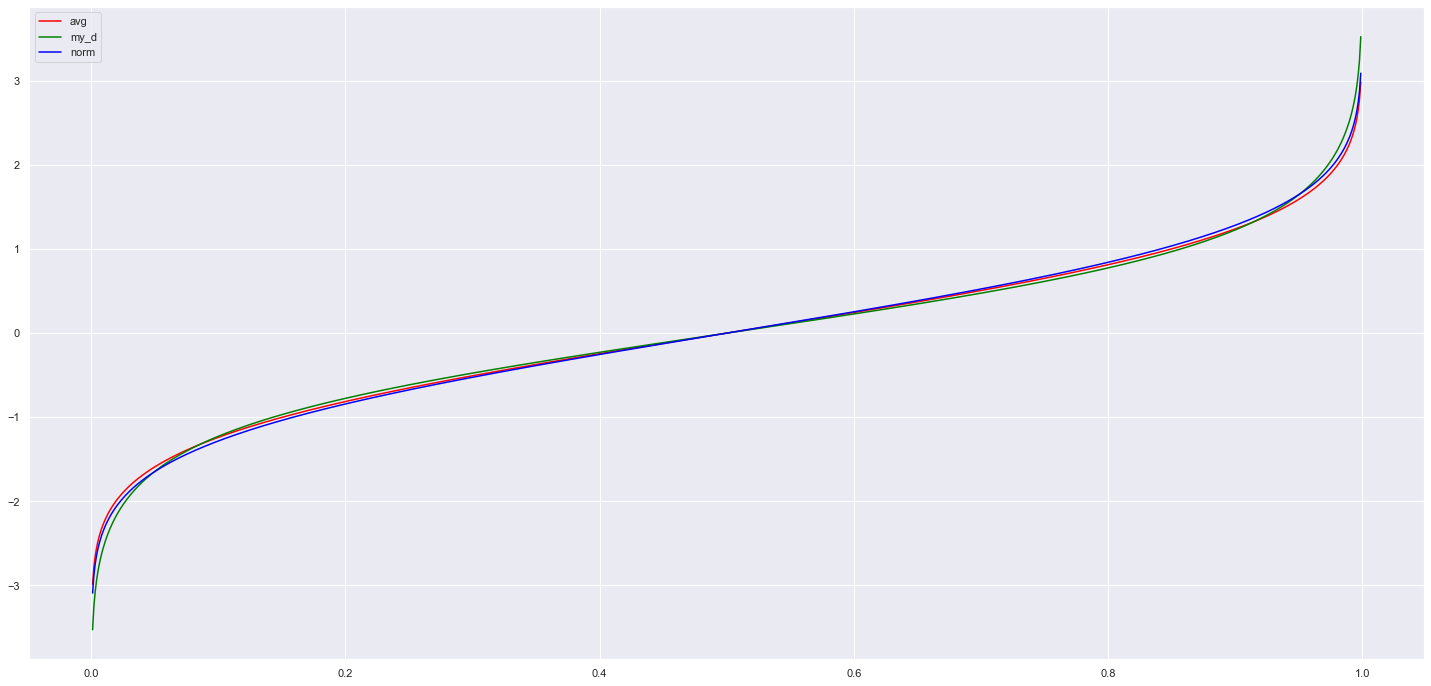

In [103]:
fig, ax = plt.subplots(figsize=(25,12))

ax.plot(xs, np.mean([low_var_ppfs, high_var_ppfs], axis=0), label='avg', color='red')
ax.plot(xs, my_d_ppfs, label='my_d', color='green')
ax.plot(xs, stats.norm.ppf(xs), label='norm', color='blue')
ax.legend();

So the average looks a lot more like the normal distribution - crucially it lacks the fatter tails that we have in our correct distribution as we can see the green tails away longer on the far left and right.

Finally let's do a quick speed check for those ppfs to see how we look compared to the SciPy normal.

In [104]:
%timeit my_d.ppf(xs)

17.2 s ± 746 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%timeit stats.norm.ppf(xs, scale=(1 - e)**0.5)

280 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [106]:
17.2*1000000 / 280

61428.57142857143

This is the issue - we are now going at a snails pace. We're now around `60,000x` slower than the SciPy built in and this will carry through to random sampling - there's no random sampling without a ppf. We need a way to create this ppf faster which requires us to:
 - integrate and create our cdf
 - invert it to create our ppf

## Attempt 2: Write our own function

Instead of asking SciPy to do the heavy lifting for us, we can create our own ppf and feed it to SciPy. Creating our own however requires us to completely define our distribution outside of the SciPy framework before feeding it in.

### Create the pdf

We've done this before so we can just produce it again.

In [108]:
def my_pdf(x, e):
    def norm_p(x, loc=0, scale=1):
        # return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * np.sqrt(2.0 * np.pi))
        return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * 2.5066282746310002)

    low = norm_p(x, scale=(1 - e)**0.5)
    high = norm_p(x, scale=(1 + e)**0.5)
    return 0.5 * (low + high)

Now we have our pdf we need to create our cdf. A cdf has to follow certain rules for this to be a valid probability distribution. To create one we need to:
 - define the domain that it operates over - anything outside the domain gets a probability of `0`
 - ensure the probabilities sum to `1`

### Create the cdf

We can create the cdf by doing the following:
 - generate a load of probabilities from the pdf at various points
 - cumulative sum those probabilities to create our cdf
 - divide this series by the max of it to return it to the interval `[0,1]`

This will give us the value of our cdf at the specified points.

In [115]:
xs = np.linspace(-5, 5, 10000001)

my_pdfs = my_d.pdf(xs)

In [116]:
my_cdf = np.cumsum(my_pdfs)
my_cdf = my_cdf / my_cdf[-1]

Let's compare this nbumerically generated cdf to that which SciPy spits out

In [117]:
xs_small = np.linspace(-5, 5, 10001)

my_d_cdf = my_d.cdf(xs_small)

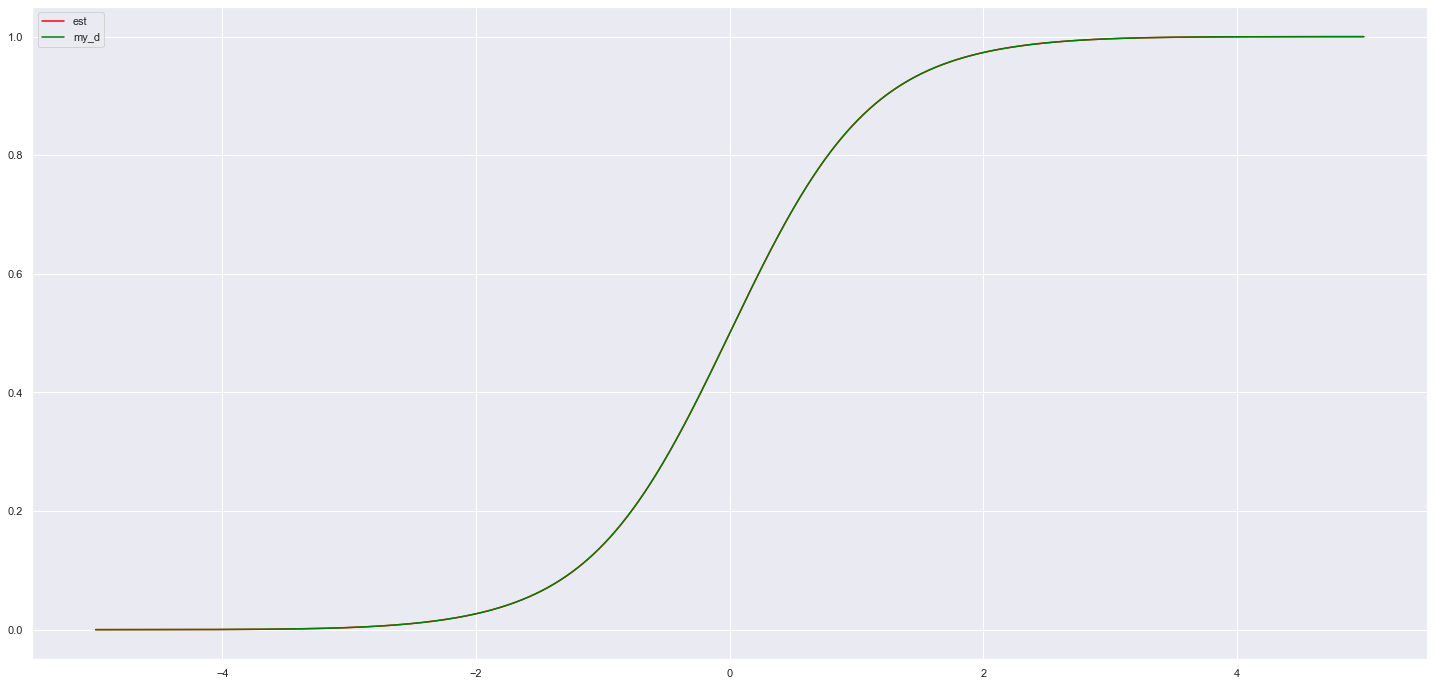

In [118]:
fig, ax = plt.subplots(figsize=(25,12))

ax.plot(xs, my_cdf, label='est', color='red')
ax.plot(xs_small, my_d_cdf, label='my_d', color='green')
ax.legend();

So it looks like we've numerically generated a good looking cdf. Let's use interpolation to translate this into a function that we could feed to our class in place of what it currently has.

In [119]:
xs = np.linspace(-25, 25, 10000001)
my_pdfs = my_d.pdf(xs)
my_cdf = np.cumsum(my_pdfs)
my_cdf = my_cdf / my_cdf[-1]

In [120]:
from scipy.interpolate import interp1d

In [122]:
func_cdf = interp1d(xs, my_cdf)

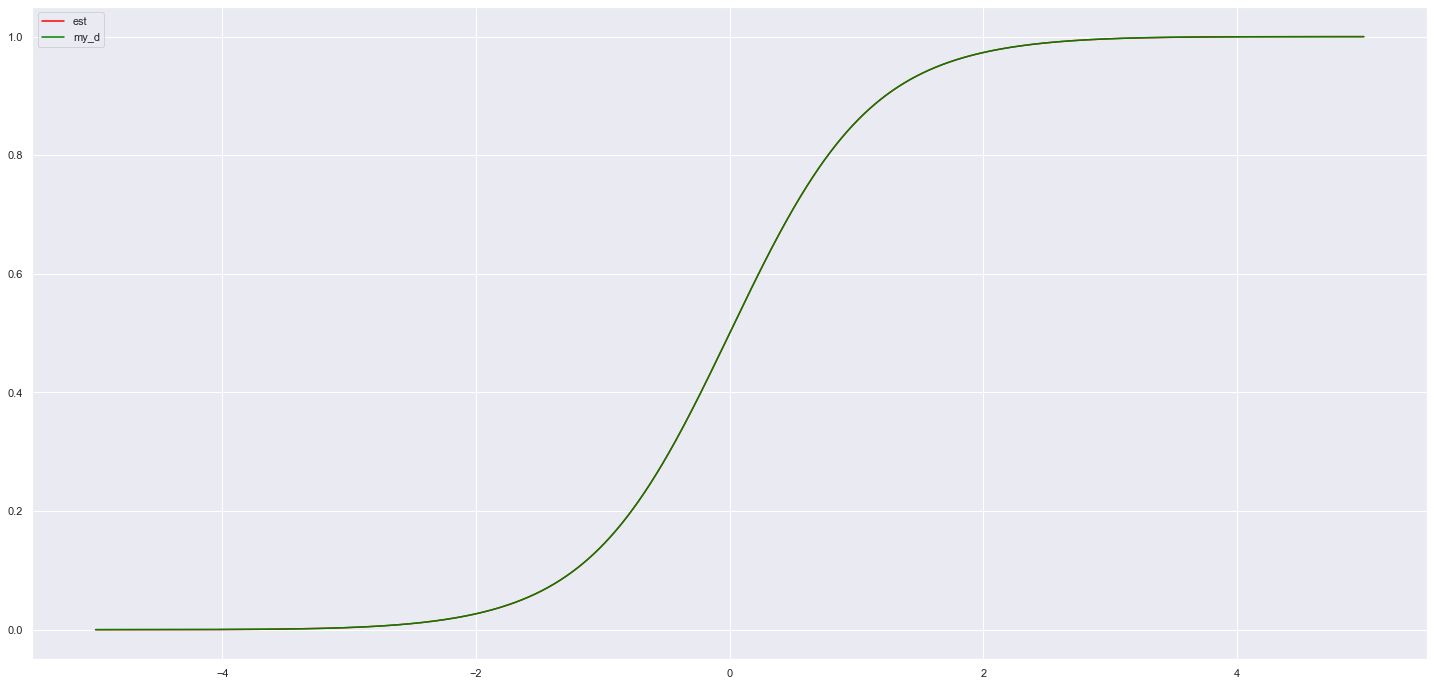

In [125]:
fig, ax = plt.subplots(figsize=(25,12))

ax.plot(xs_small, func_cdf(xs_small), label='est', color='red')
ax.plot(xs_small, my_d_cdf, label='my_d', color='green')
ax.legend();

So now that we've functionalised it it looks pretty good. Let's see how the speed compares of the built in SciPy cdf creator vs what we've done.

In [126]:
%timeit func_cdf(xs_small)

5.54 ms ± 767 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [127]:
%timeit my_d.cdf(xs_small)

8.21 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Much better - we've sped it up `1,500x`. Let's now add this to our class. We'll need to create it initially in the init method and then we can apply it when we call the cdf method.

### Update class with cdf creator

In [191]:
# define our gaussian look-a-like distribution
class my_dist(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
        
        def _create_cdf_func():
            # this is where we create the cdf function
            xs = np.linspace(-25, 25, 10000001)
            my_pdfs = self.pdf(xs)
            my_cdf = np.cumsum(my_pdfs)
            my_cdf = my_cdf / my_cdf[-1]
            func_cdf = interp1d(xs, my_cdf)
            return func_cdf
        self.cdf_func = _create_cdf_func()
        
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        def norm_p(x, loc=0, scale=1):
            # return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * np.sqrt(2.0 * np.pi))
            return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * 2.5066282746310002)
    
        low = norm_p(x, scale=(1 - self.e)**0.5)
        high = norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)
    
    def _cdf(self, x):
        return self.cdf_func(x)

In [134]:
e = 0.5
my_d = my_dist(e, name='my_dist')

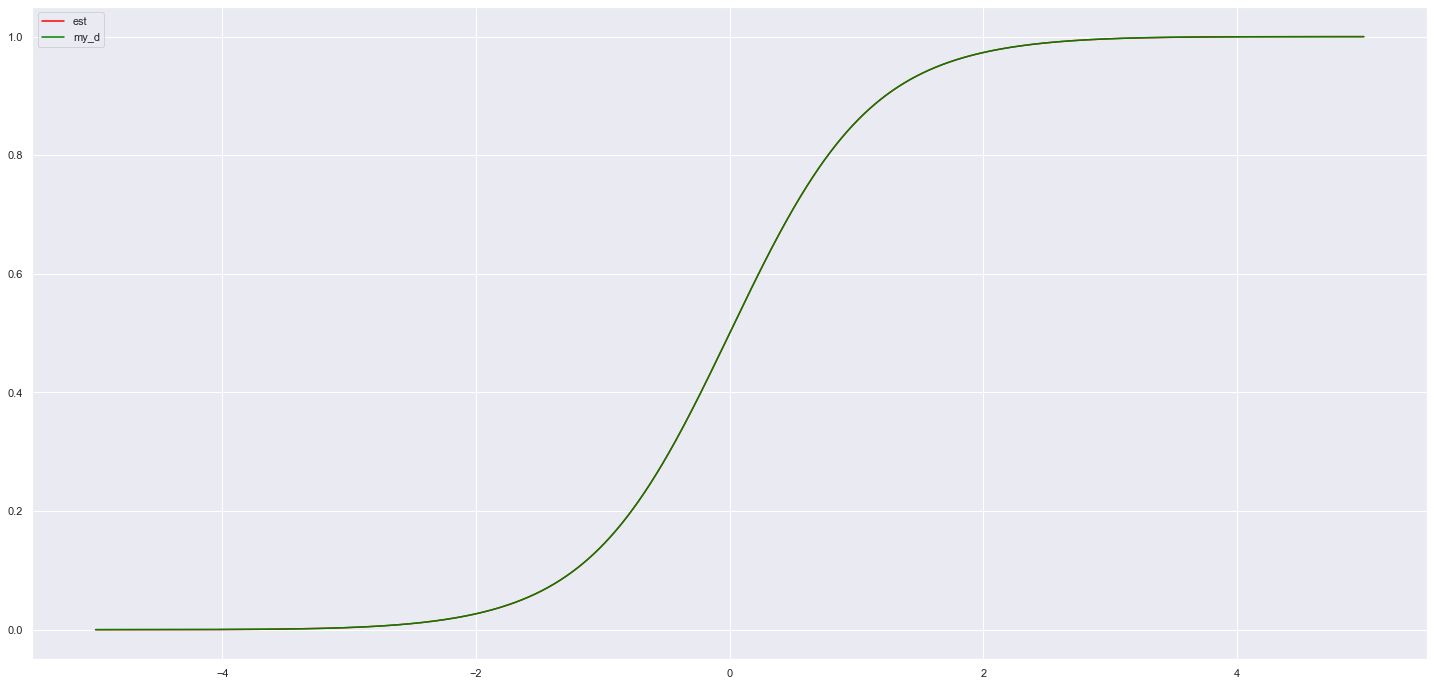

In [136]:
fig, ax = plt.subplots(figsize=(25,12))

ax.plot(xs_small, my_d.cdf(xs_small), label='est', color='red')
ax.plot(xs_small, my_d_cdf, label='my_d', color='green')
ax.legend();

In [139]:
xs = np.linspace(-20, 20, 1000001)

In [140]:
%timeit my_d.cdf(xs)

111 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [141]:
%timeit stats.norm.cdf(xs_small)

670 µs ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Perfect, so we're making progress - still slower but we're down to around 100ms second for `1,000,000` cdfs. We now have a _slight_ load time when we initiate our distribution class but it's worth the upfront cdf creation for blazin' fast sampling.

### Create the ppf

Alrighty so we have used SciPy's clever interpolation to create a python function that represents our cdf. Now we need the final step - to invert that cdf and assign this to our ppf function.

In [189]:
# define our gaussian look-a-like distribution
class my_dist_ppf(stats.rv_continuous):
    
    # define init with sigma deviation param e
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
        
        def _create_funcs():
            # this is where we create the cdf function
            xs = np.linspace(-25, 25, 10000001)
            my_pdfs = self.pdf(xs)
            my_cdf = np.cumsum(my_pdfs)
            my_cdf = my_cdf / my_cdf[-1]
            func_cdf = interp1d(xs, my_cdf)
            func_ppf = interp1d(my_cdf, xs, fill_value='extrapolate')
            return func_cdf, func_ppf
        self.cdf_func, self.ppf_func = _create_funcs()
        
    # define the internal pdf method with our pdf
    def _pdf(self, x):
        def norm_p(x, loc=0, scale=1):
            # return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * np.sqrt(2.0 * np.pi))
            return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * 2.5066282746310002)
    
        low = norm_p(x, scale=(1 - self.e)**0.5)
        high = norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)
    
    def _cdf(self, x):
        return self.cdf_func(x)
    
    def _ppf(self, x):
        return self.ppf_func(x)

In [188]:
?? my_d_2._ppf_to_solve

Signature:  my_d_2._ppf_to_solve(x, q, *args)
Docstring: <no docstring>
Source:   
    def _ppf_to_solve(self, x, q, *args):
        return self.cdf(*(x, )+args)-q
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [192]:
e = 0.5
my_d = my_dist(e, name='my_dist')
my_d_2 = my_dist_ppf(e, name='my_dist_ppf')

In [193]:
xs = np.linspace(0, 1, 1001)

In [200]:
my_d_ppf = my_d.ppf(xs)

In [201]:
my_d_2_ppf = my_d_2.ppf(xs)

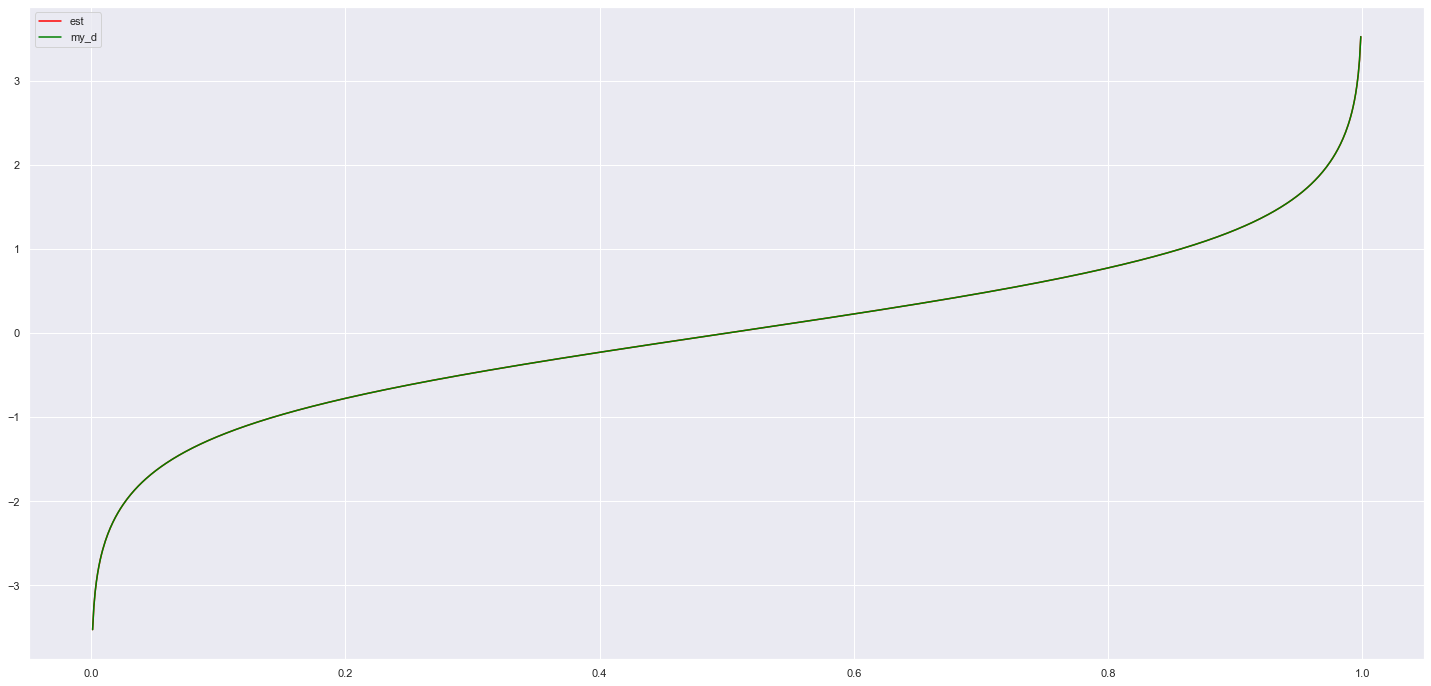

In [203]:
fig, ax = plt.subplots(figsize=(25,12))

ax.plot(xs, my_d_2_ppf, label='est', color='red')
ax.plot(xs, my_d_ppf, label='my_d', color='green')
ax.legend();

So we seem to line up perfectly. Let's time things and see how we fare.

In [204]:
%timeit my_d.ppf(xs)

5 s ± 626 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [205]:
%timeit my_d_2.ppf(xs)

934 µs ± 94.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [223]:
%timeit snorm.ppf(xs)

394 µs ± 83.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


So we're around `3x` slower than SciPy for the normal distribution but much much faster than before. We've sped things up over `5,000x`.

Finally let's compare our returned distribution vs a normal distribution to see why we went through this in the first place.

In [214]:
e = 0.8
my_d_2 = my_dist_ppf(e, name='my_dist')
snorm = stats.norm()

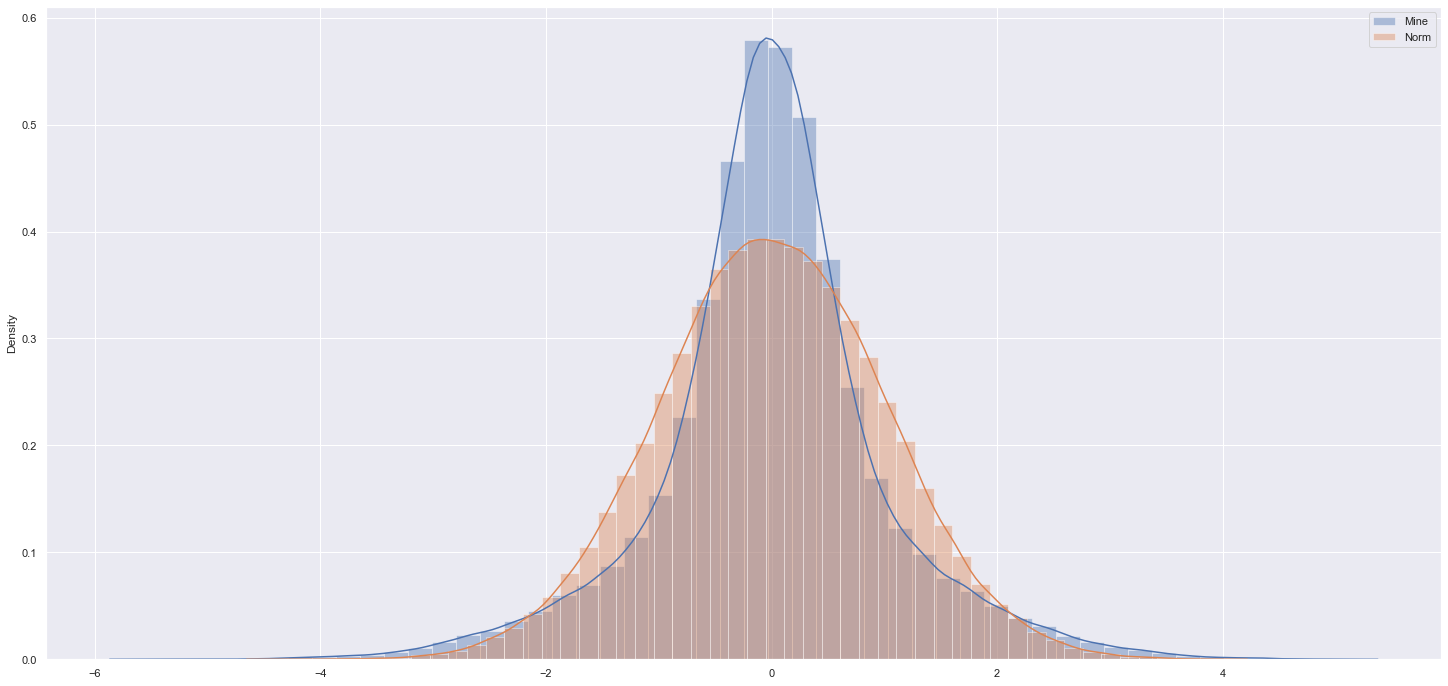

In [227]:
n = 100000

fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(my_d_2.rvs(size=n), ax=ax, kde=True, label='Mine')
sns.distplot(snorm.rvs(size=n), ax=ax, kde=True, label='Norm')
ax.legend();

In [216]:
np.var(my_d_2.rvs(size=n))

1.0020365161650666

In [217]:
np.var(stats.norm.rvs(size=n))

1.000149517393871

In [218]:
stats.kurtosis(my_d_2.rvs(size=n))

1.8959481373313833

In [219]:
stats.kurtosis(stats.norm.rvs(size=n))

-0.007347842862907683

In [220]:
%timeit my_d_2.rvs(size=n)

132 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [222]:
%timeit snorm.rvs(size=n)

3.97 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [228]:
import numpy as np
from scipy.stats import rv_discrete

# these are your variables X
vals = [1, 2, 3]
# these are the fractions they occur
probs = [0.2, 0.5, 0.3]

# define discrete distribution
distrib = rv_discrete(values=(range(len(vals)), probs))

# sample 10 values from this distribution
distrib.rvs(size=10)

array([1, 0, 1, 2, 1, 1, 0, 1, 1, 1])

In [229]:
[vals[x] for x in distrib.rvs(size=10)]

[3, 2, 3, 2, 2, 2, 1, 1, 2, 2]

In [237]:
%timeit [vals[x] for x in distrib.rvs(size=1000000)]

233 ms ± 36.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [233]:
%timeit np.random.choice(vals, size=10000, p=probs)

639 µs ± 204 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [238]:
distrib = rv_discrete(values=(range(len(vals)), probs))

In [239]:
%timeit [vals[x] for x in distrib.rvs(size=1000000)]

358 ms ± 204 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [240]:
distrib = rv_discrete(values=(range(len(vals)), probs), seed=np.random.default_rng(123)) 

In [241]:
%timeit [vals[x] for x in distrib.rvs(size=1000000)]

221 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
